# Anomaly detection for time series

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length,plotFig
from sklearn.preprocessing import MinMaxScaler

from TSB_UAD.models.norma import NORMA
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.lof import LOF
from TSB_UAD.models.matrix_profile import MatrixProfile
from TSB_UAD.models.pca import PCA
from TSB_UAD.models.poly import POLY
from TSB_UAD.models.ocsvm import OCSVM
from TSB_UAD.models.lstm import lstm
from TSB_UAD.models.AE_mlp2 import AE_MLP2
from TSB_UAD.models.cnn import cnn

from TSB_UAD.models.damp import DAMP
from TSB_UAD.models.sand import SAND


##  Data preprocessing

Here we load and prepare the time series (here, we load only a snippet of 10,000 points). We asutomatically estimate the subsequence length for the anomaly detection methods that require a subsequence length parameter.
In order to do this, we use auto-correlation

In [2]:
# Prepare data for unsupervised method

filepath = '../../data/benchmark/ECG/MBA_ECG805_data.out'
df = pd.read_csv(filepath, header=None).to_numpy()

name = filepath.split('/')[-1]
max_length = 10000

data = df[:max_length,0].astype(float)
label = df[:max_length,1]
    
slidingWindow = find_length(data)
X_data = Window(window = slidingWindow).convert(data).to_numpy()


# Prepare data for semisupervised method. 
# Here, the training ratio = 0.1

data_train = data[:int(0.1*len(data))]
data_test = data

X_train = Window(window = slidingWindow).convert(data_train).to_numpy()
X_test = Window(window = slidingWindow).convert(data_test).to_numpy()

## Display the results of 11 anomaly detectors

For each output figure, the left panel shows the real time series with outliers (red), anomaly score obtained by each anomaly detector, and the correpsonding TP/FP/TN/FN classification. 

The right panel shows the ROC curve. AUC represents the area under the ROC curve. Larger AUC indicates better performance.

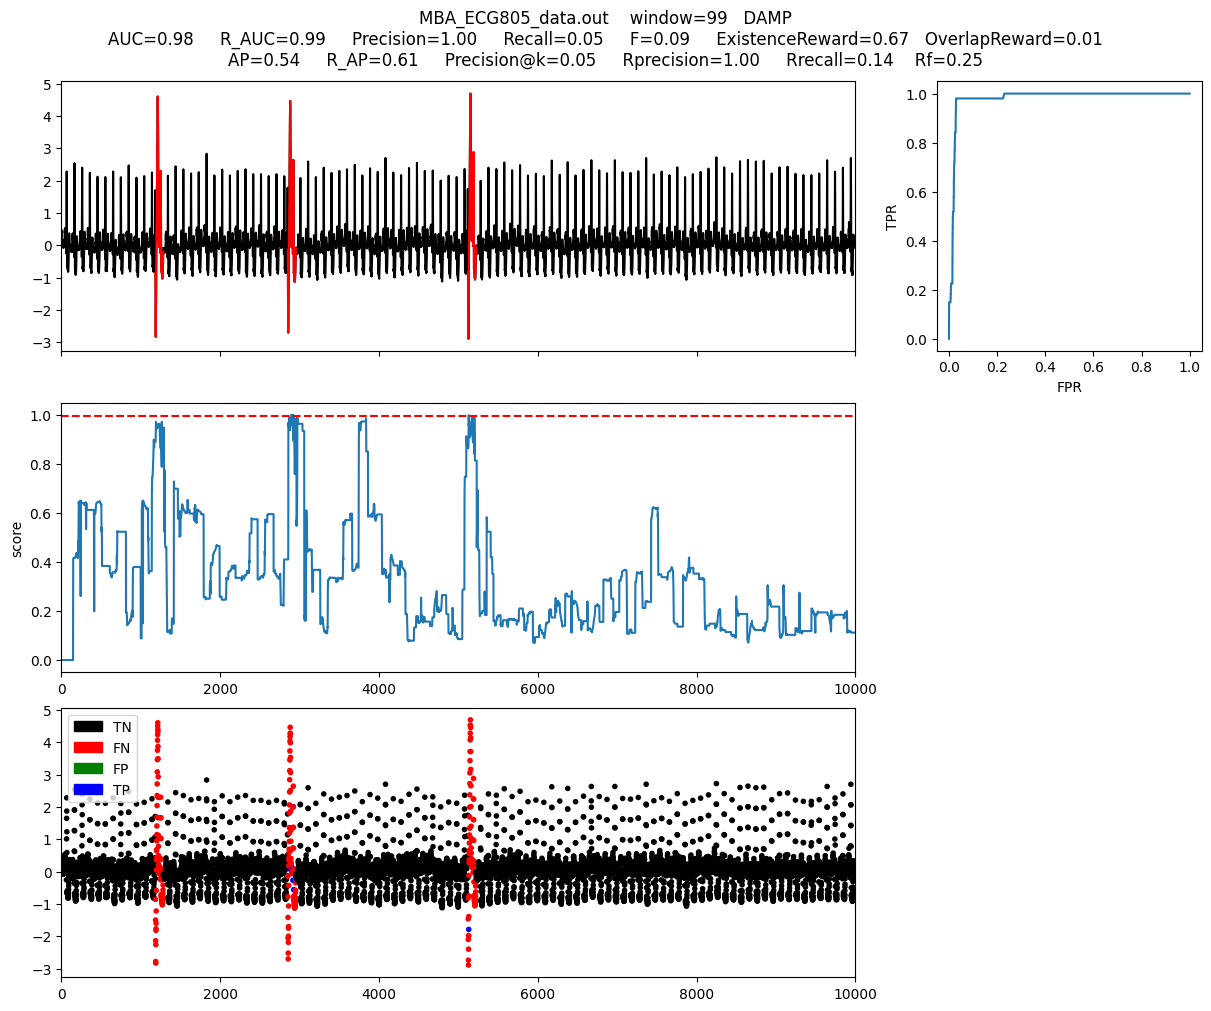

In [3]:
modelName='DAMP'
clf = DAMP(m = slidingWindow,sp_index=slidingWindow+1)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

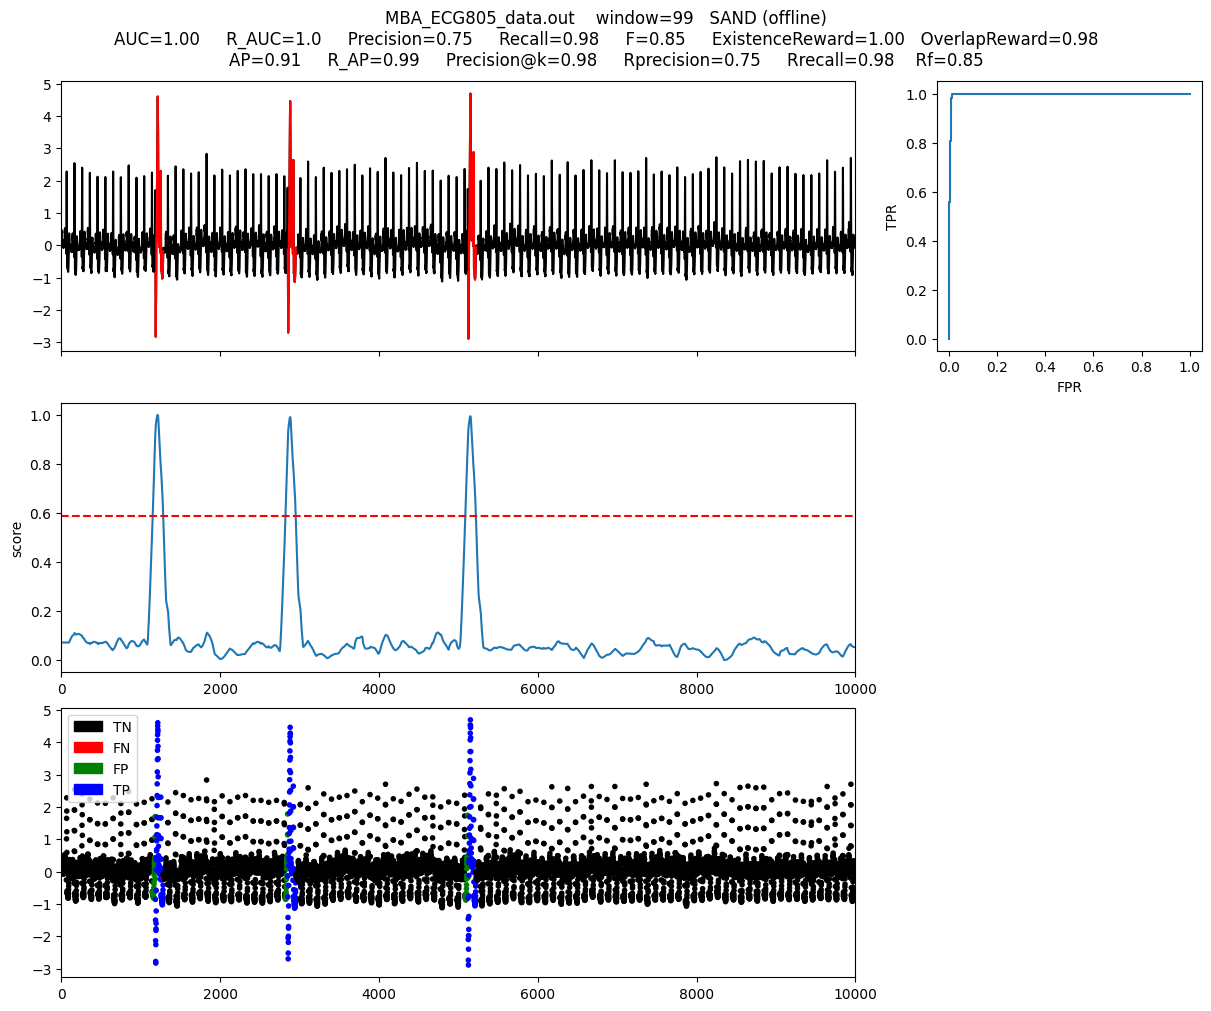

In [6]:
modelName='SAND (offline)'
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
x = data
clf.fit(x,overlaping_rate=slidingWindow//2)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

0-->5000-->7000-->9000-->[STOP]: score length 10000


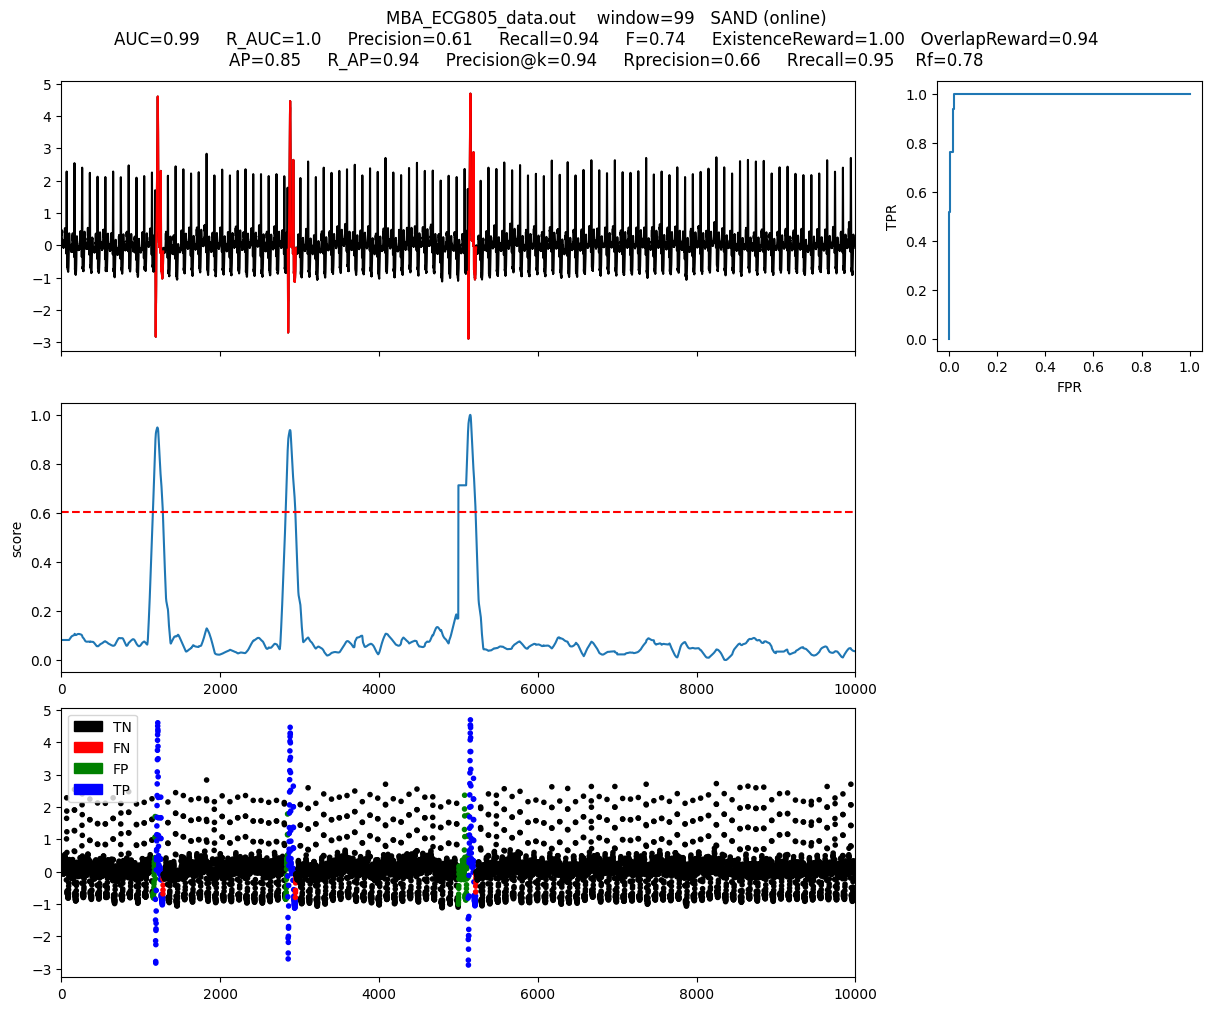

In [9]:
modelName='SAND (online)'
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
x = data
clf.fit(x,online=True,alpha=0.5,init_length=5000,batch_size=2000,verbose=True)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

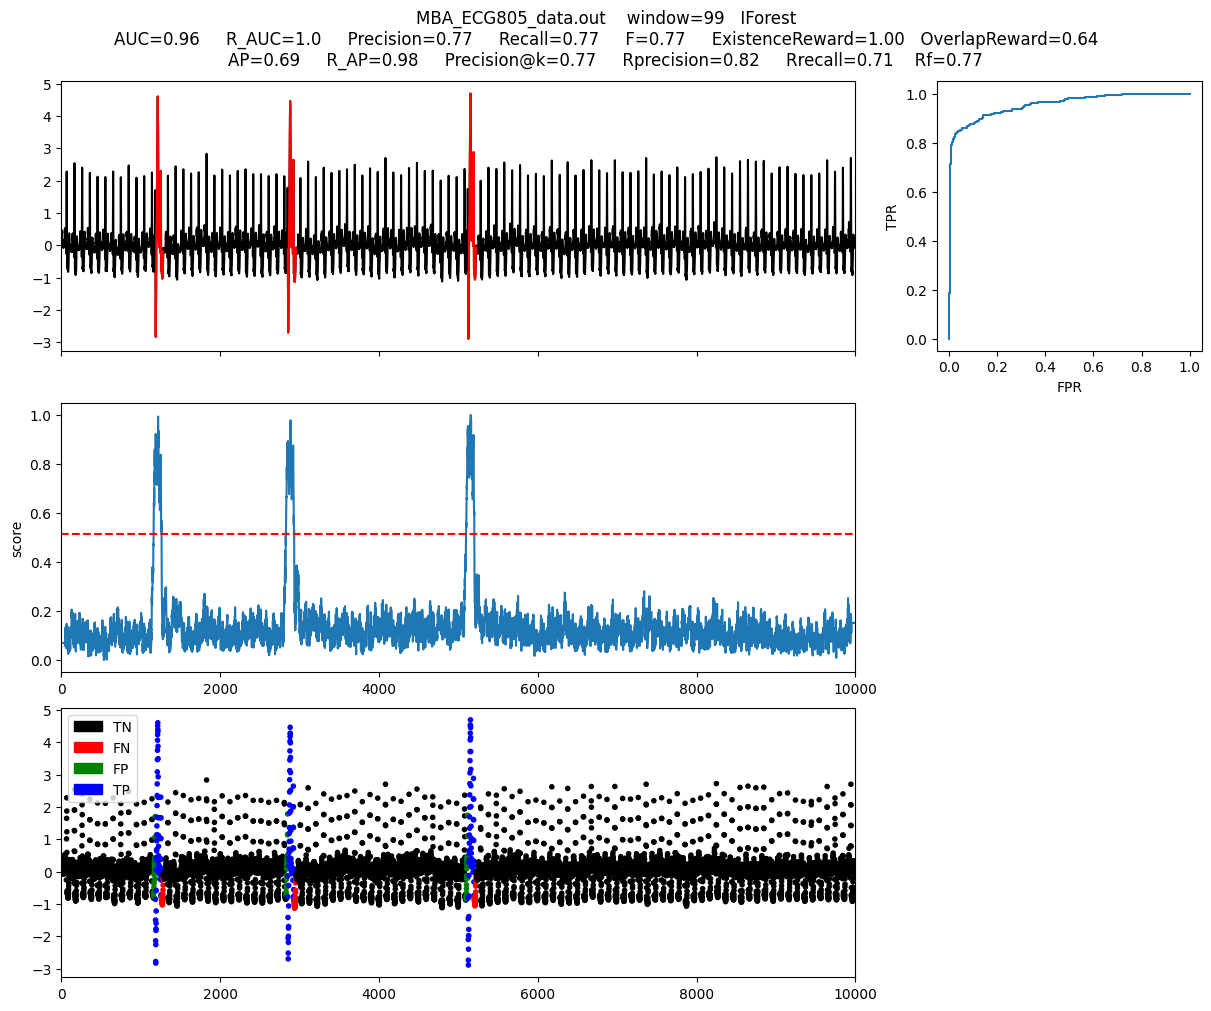

In [4]:
modelName='IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

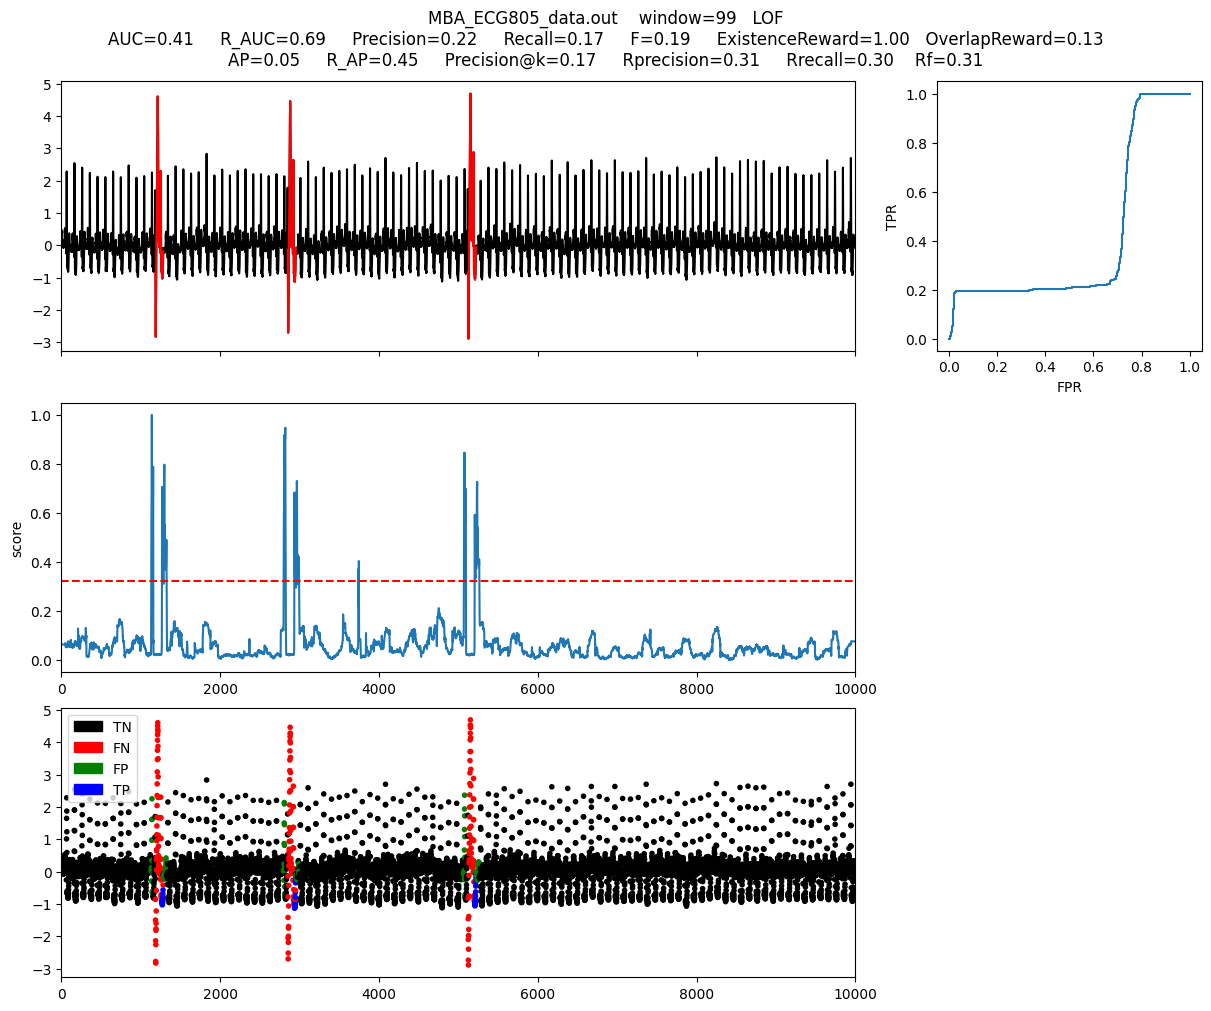

In [5]:
modelName='LOF'
clf = LOF(n_neighbors=20, n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

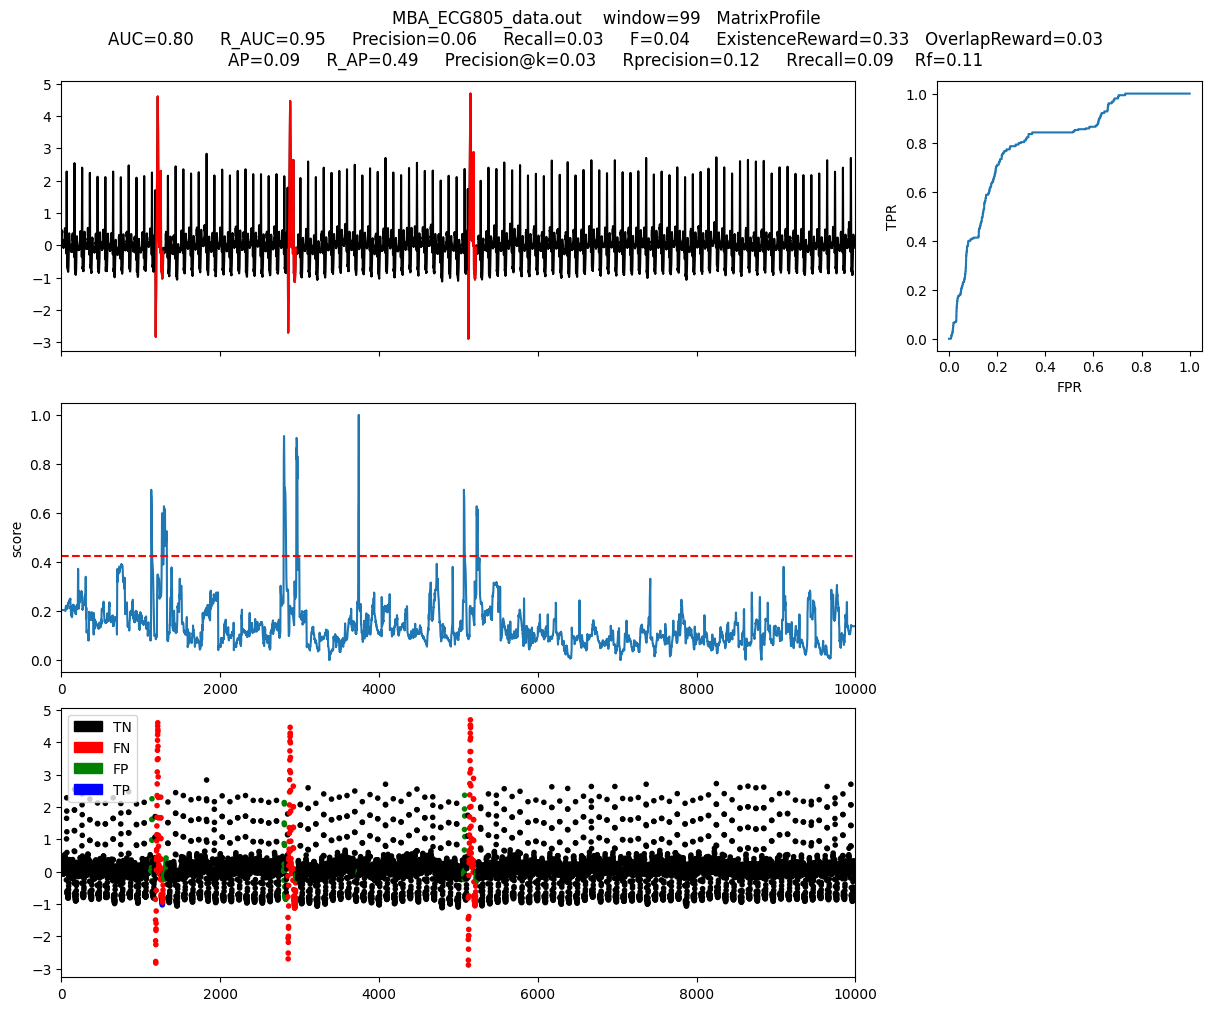

In [6]:
modelName='MatrixProfile'
clf = MatrixProfile(window = slidingWindow)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

Normal Model Length/number of subsequences selected:  (297, 10)


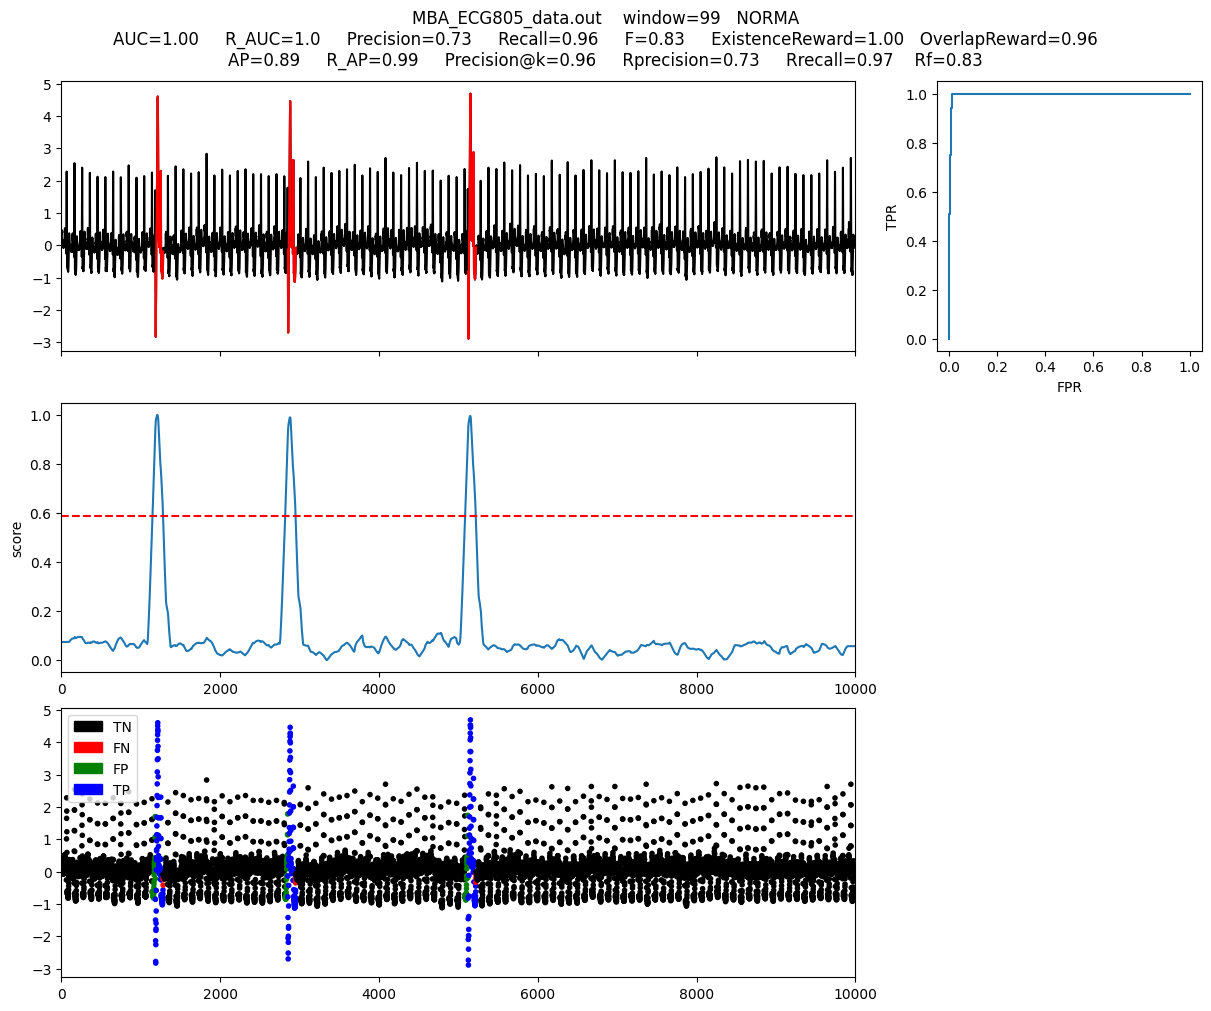

In [7]:
modelName='NORMA'
clf = NORMA(pattern_length = slidingWindow, nm_size=3*slidingWindow)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*((slidingWindow-1)//2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

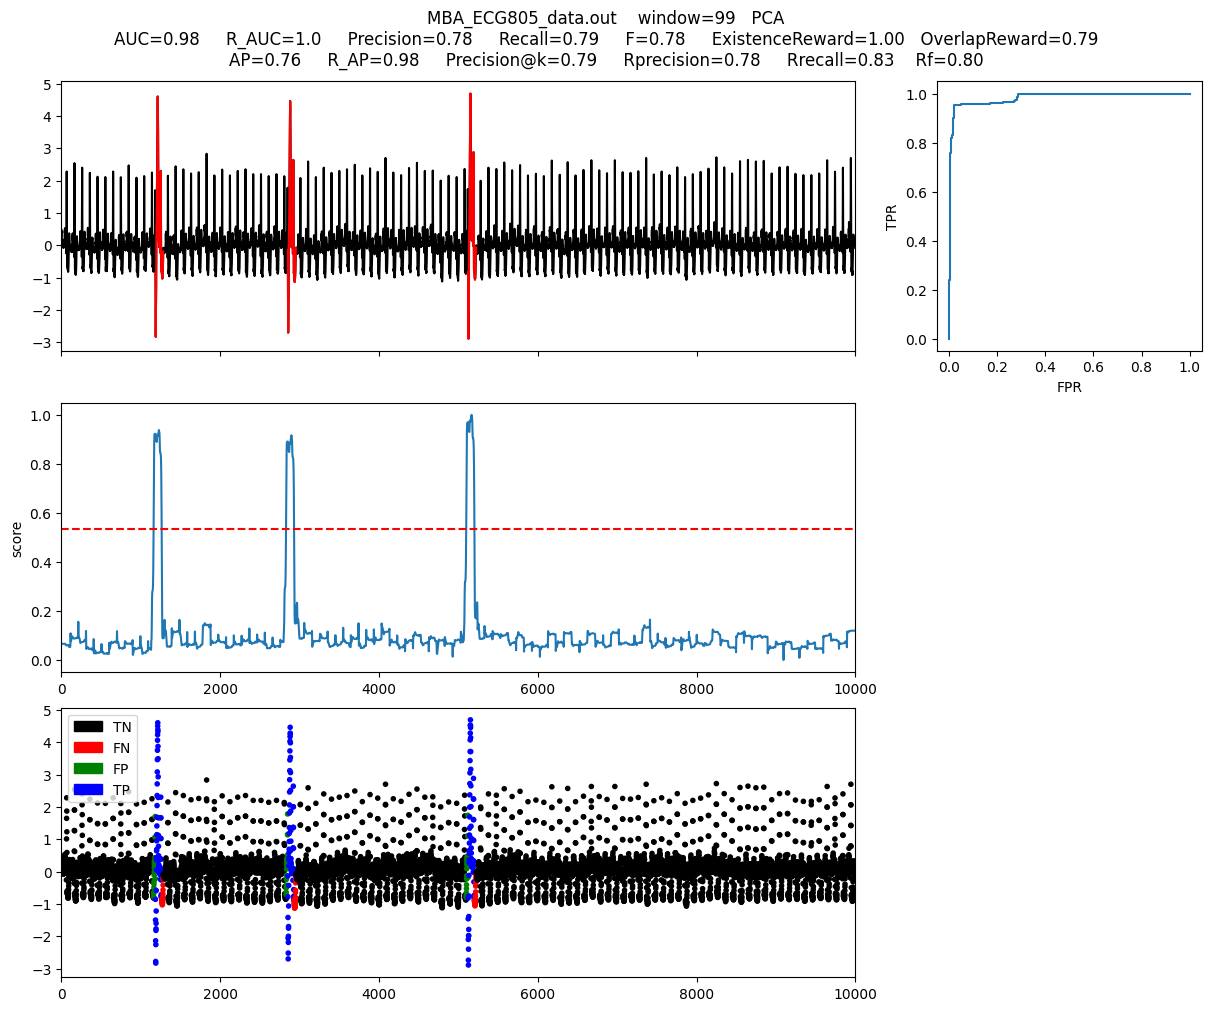

In [8]:
modelName='PCA'
clf = PCA()
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

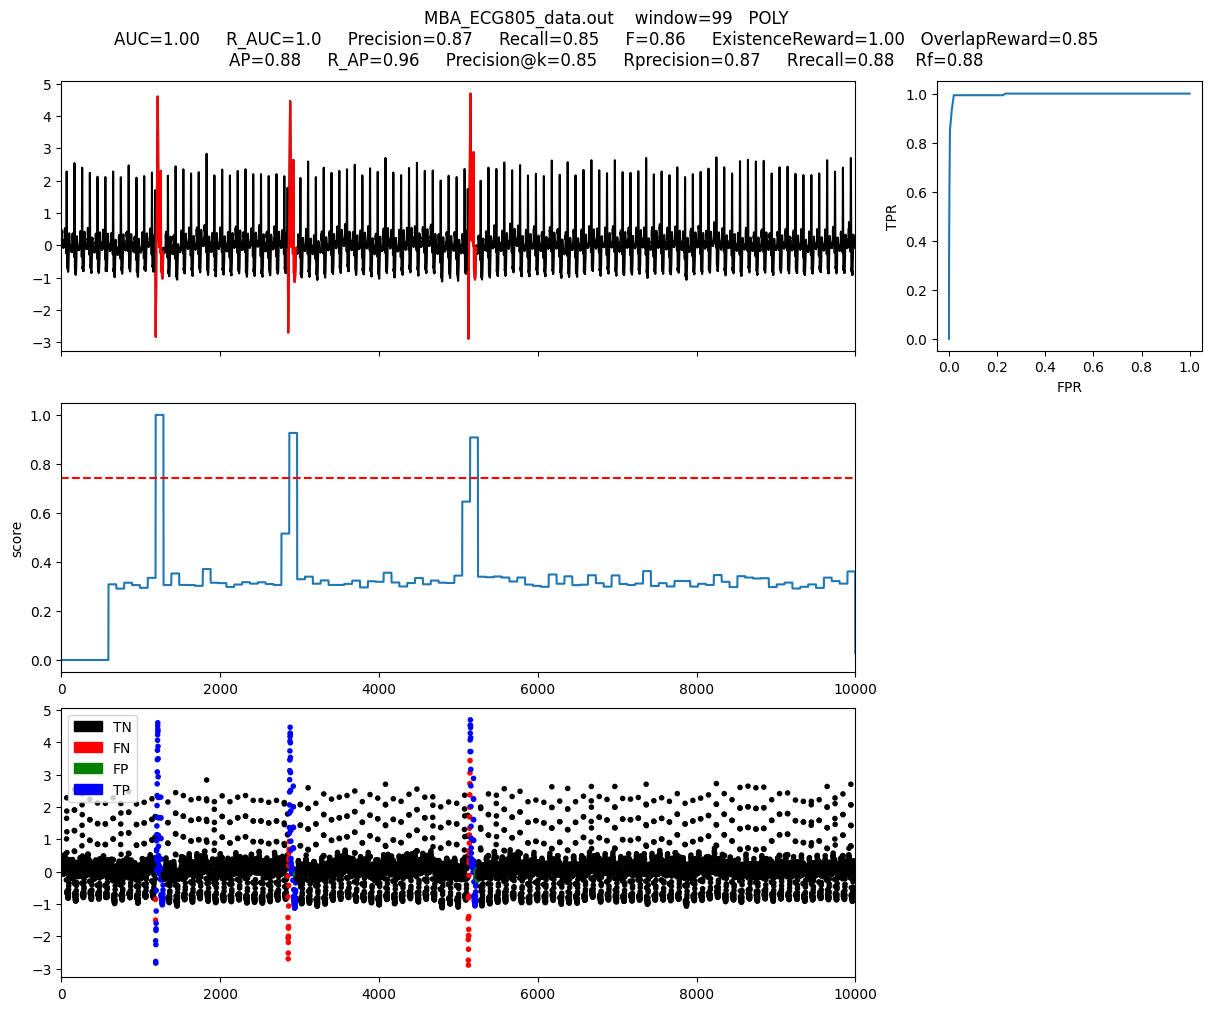

In [9]:
modelName='POLY'
clf = POLY(power=3, window = slidingWindow)
x = data
clf.fit(x)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

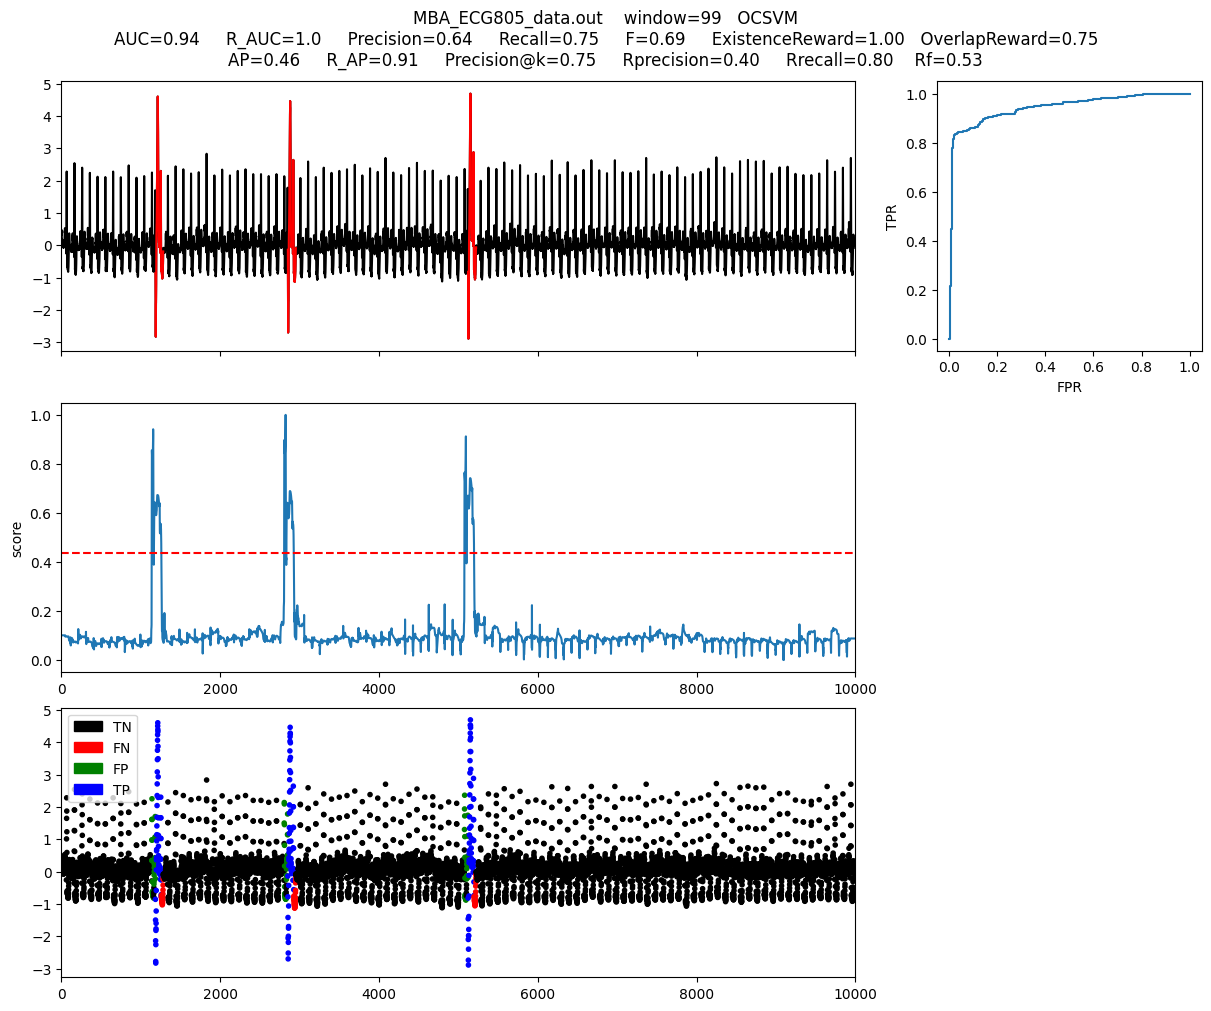

In [10]:
modelName='OCSVM'
X_train_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_train.T).T
X_test_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_test.T).T

clf = OCSVM(nu=0.05)
clf.fit(X_train_, X_test_)


score = clf.decision_scores_
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

2022-12-06 18:42:46.632805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


310/310 [==============================] - 5s 13ms/step


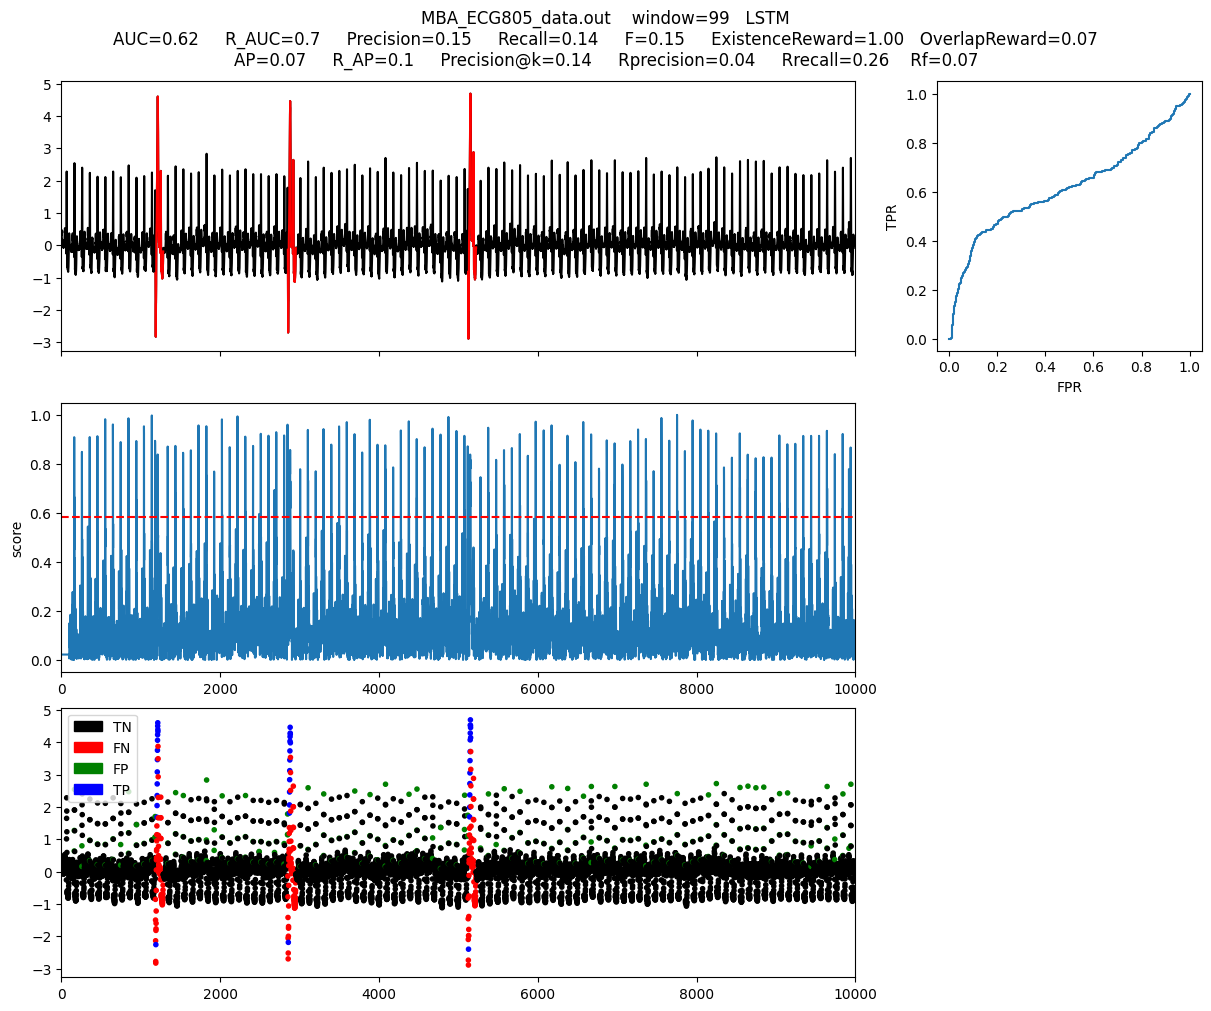

In [11]:
modelName='LSTM'
clf = lstm(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

310/310 [==============================] - 0s 672us/step


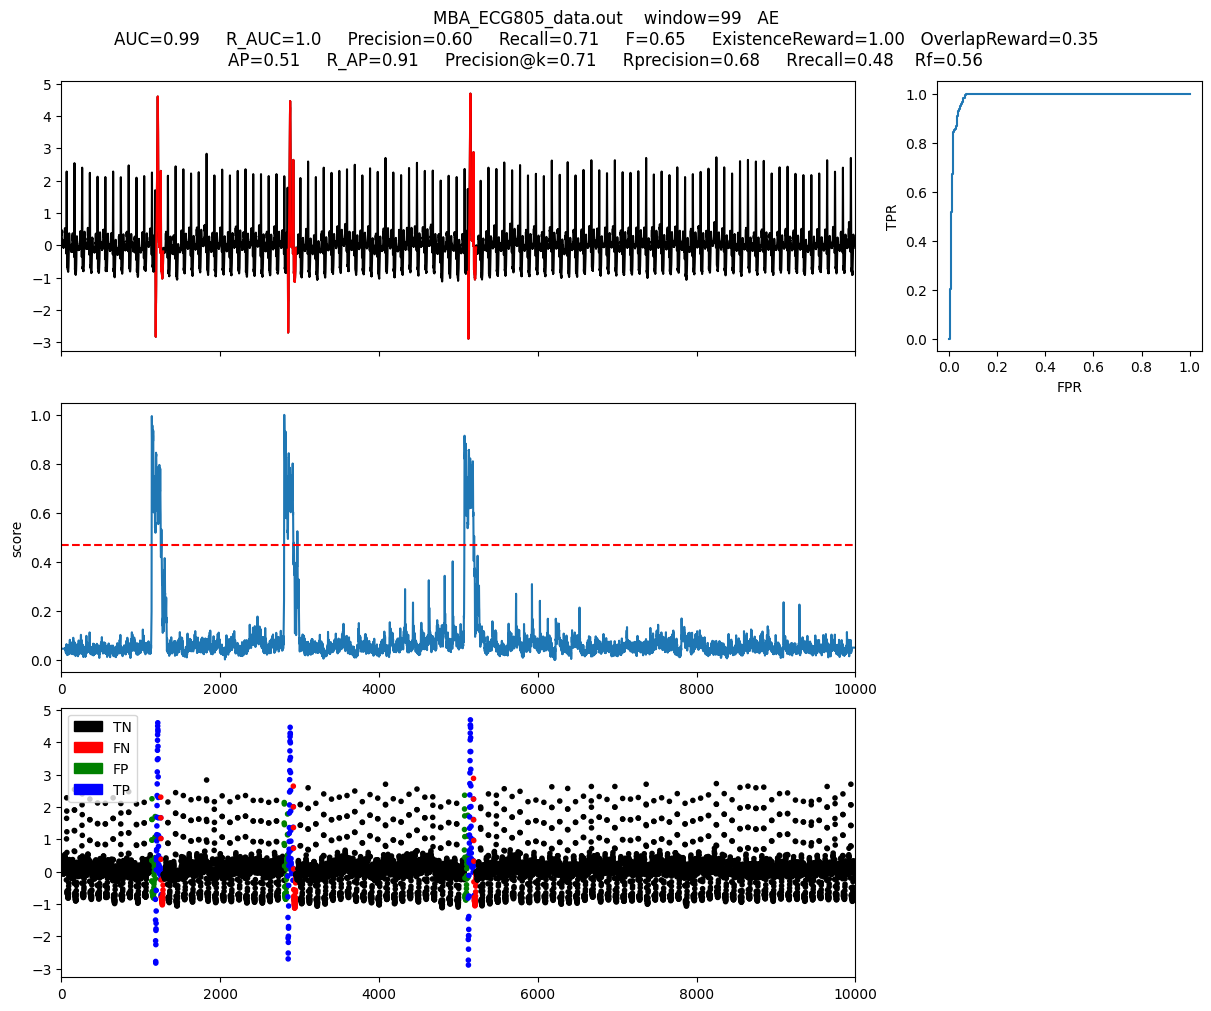

In [12]:
modelName='AE'
clf = AE_MLP2(slidingWindow = slidingWindow, epochs=100, verbose=0)

clf.fit(data_train, data_test)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

310/310 [==============================] - 0s 1ms/step


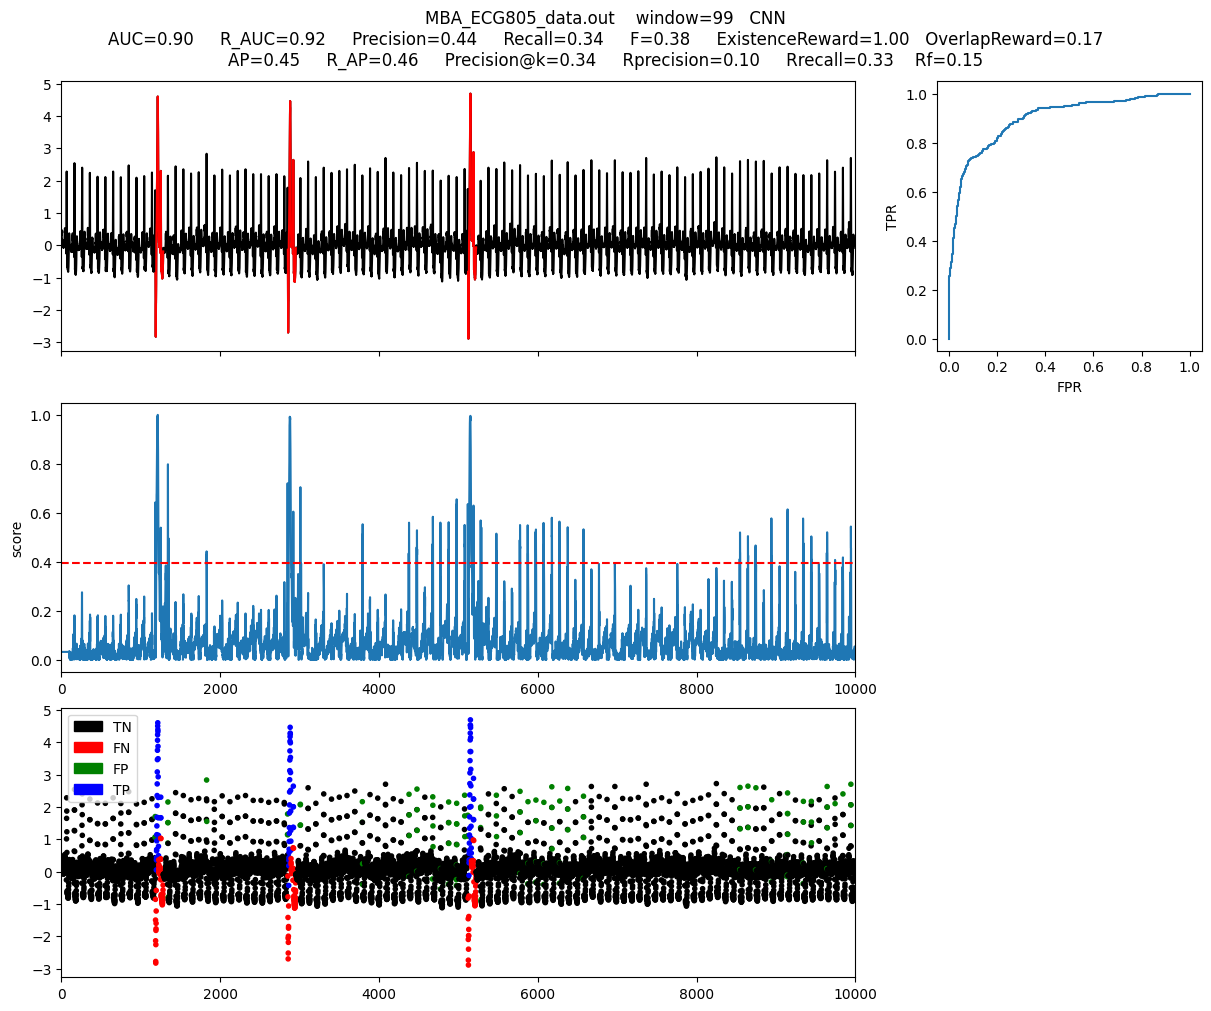

In [13]:
modelName='CNN'
clf = cnn(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 100, patience = 5, verbose=0)

clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)